# Лабораторная работа 1. Нейронные сети.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за всю работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_01.ipynb.

# Часть 1. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

cifar10.load_data() не работает, поэтому скачиваем данные другим путем

In [3]:
# Load data. It may work slow.
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  6660k      0  0:00:25  0:00:25 --:--:-- 7432k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Функции, помогающие прочитать данные в нужном формате

In [0]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import os
import _pickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='iso-8859-1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [5]:
cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)
class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

Кроме того, заметим, что мы имеем не совсем подходящую размерность для imshow (3 - первая размерность картинки). Поэтому изменим размерности

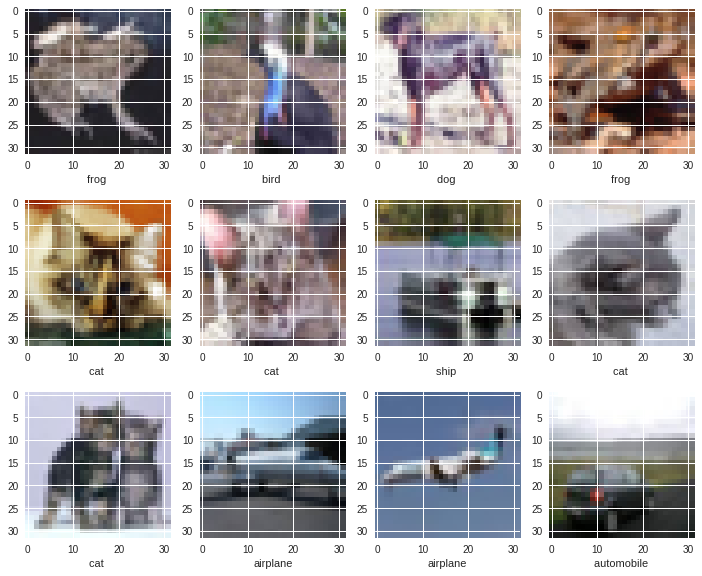

In [6]:
X_train = X_train.transpose(0, 2, 3, 1)
X_val = X_val.transpose(0, 2, 3, 1)
X_test = X_test.transpose(0, 2, 3, 1)

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(X_train[i].astype('uint8'))
plt.show()

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

В этой клетке и в некоторых клетках далее стоят [0], что-то произошло при скачивании с Colab-а

In [0]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [0]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [0]:
import keras, keras.layers as L
from keras.models import Model

Создайте полносвязную сеть:

Создадим обычную полносвязную сеть с двумя слоями

In [0]:
input_images = L.Input(shape=(32, 32, 3), name='images')
flattened_images = L.Flatten()(input_images)
first_layer = L.Dense(64, activation='relu')(flattened_images)
dropout_layer = L.Dropout(0.25)(first_layer)
second_layer = L.Dense(10, activation='softmax')(dropout_layer)
model = Model(inputs=[input_images], outputs=[second_layer])

In [0]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Обучение сети

**Задание 1.1 (1 балл)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

Берем предыдущую архитектуру. К методу оптимизации также добавим nesterov momentum и уменьшение learning rate с итерациями.

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import optimizers

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                196672    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


Обучаемся. Будем пользоваться такими callback-ами как EarlyStopping и TensorBoard

In [0]:
earlystopper = EarlyStopping(patience=7, verbose=1)
tensorboard = TensorBoard(log_dir="./logs/{}".format(2))
callbacks_list = [tensorboard, earlystopper]
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 3s 76us/step - loss: 2.2251 - acc: 0.1779 - val_loss: 2.1376 - val_acc: 0.2347
Epoch 2/100
40000/40000 [==============================] - 3s 68us/step - loss: 2.1128 - acc: 0.2367 - val_loss: 2.0633 - val_acc: 0.2536
Epoch 3/100
40000/40000 [==============================] - 2s 62us/step - loss: 2.0511 - acc: 0.2636 - val_loss: 2.0045 - val_acc: 0.2776
Epoch 4/100
40000/40000 [==============================] - 2s 49us/step - loss: 2.0090 - acc: 0.2772 - val_loss: 1.9696 - val_acc: 0.2964
Epoch 5/100
40000/40000 [==============================] - 2s 50us/step - loss: 1.9731 - acc: 0.2941 - val_loss: 1.9251 - val_acc: 0.3308
Epoch 6/100
40000/40000 [==============================] - 2s 48us/step - loss: 1.9504 - acc: 0.3057 - val_loss: 1.9230 - val_acc: 0.3163
Epoch 7/100
40000/40000 [==============================] - 2s 48us/step - loss: 1.9259 - acc: 0.3161 - val_loss: 1.8933 - 

Ну, видим, что 100 эпох оказалось мало. Давайте сделаем еще 100.

In [0]:
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 57us/step - loss: 1.6371 - acc: 0.4277 - val_loss: 1.6165 - val_acc: 0.4355
Epoch 2/100
40000/40000 [==============================] - 2s 54us/step - loss: 1.6374 - acc: 0.4291 - val_loss: 1.6118 - val_acc: 0.4315
Epoch 3/100
40000/40000 [==============================] - 2s 50us/step - loss: 1.6355 - acc: 0.4260 - val_loss: 1.6040 - val_acc: 0.4347
Epoch 4/100
40000/40000 [==============================] - 2s 49us/step - loss: 1.6328 - acc: 0.4305 - val_loss: 1.6149 - val_acc: 0.4358
Epoch 5/100
40000/40000 [==============================] - 2s 51us/step - loss: 1.6273 - acc: 0.4310 - val_loss: 1.5974 - val_acc: 0.4411
Epoch 6/100
40000/40000 [==============================] - 2s 51us/step - loss: 1.6311 - acc: 0.4273 - val_loss: 1.6122 - val_acc: 0.4308
Epoch 7/100
40000/40000 [==============================] - 2s 51us/step - loss: 1.6261 - acc: 0.4331 - val_loss: 1.6225 - 

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.4567
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (1 балл)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

Пишем нейронку как описано выше

In [0]:
input_images = L.Input(shape=(32, 32, 3), name='images')
cnn_layer = L.Conv2D(filters=10, kernel_size=(3, 3))(input_images)
relu_layer = L.Activation('relu')(cnn_layer)
pooling = L.MaxPool2D(pool_size=(2, 2))(relu_layer)
flattened_vector = L.Flatten()(pooling)
dense_layer = L.Dense(100, activation='relu')(flattened_vector)
output = L.Dense(10, activation='softmax')(dense_layer)

model = Model(inputs=[input_images], outputs=[output])

Зададим оптимайзер и посмотрим на саммари модели

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 10)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 2250)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               225100    
_________________________________________________________________
dense_40 (Dense)             (None, 10)                1010      
Total para

Обучаемся

In [0]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(3))
callbacks_list = [tensorboard]
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 16s 407us/step - loss: 2.2195 - acc: 0.1870 - val_loss: 2.1413 - val_acc: 0.2344
Epoch 2/100
40000/40000 [==============================] - 16s 396us/step - loss: 2.0809 - acc: 0.2559 - val_loss: 2.0387 - val_acc: 0.2738
Epoch 3/100
40000/40000 [==============================] - 16s 393us/step - loss: 1.9958 - acc: 0.2895 - val_loss: 2.0101 - val_acc: 0.2529
Epoch 4/100
40000/40000 [==============================] - 15s 377us/step - loss: 1.9418 - acc: 0.3118 - val_loss: 1.9519 - val_acc: 0.2907
Epoch 5/100
40000/40000 [==============================] - 15s 382us/step - loss: 1.9035 - acc: 0.3287 - val_loss: 1.9321 - val_acc: 0.3023
Epoch 6/100
40000/40000 [==============================] - 15s 387us/step - loss: 1.8731 - acc: 0.3421 - val_loss: 1.8645 - val_acc: 0.3372
Epoch 7/100
40000/40000 [==============================] - 17s 422us/step - loss: 1.8460 - acc: 0.3537 - val_l

Epoch 59/100
40000/40000 [==============================] - 16s 396us/step - loss: 1.2828 - acc: 0.5512 - val_loss: 1.3712 - val_acc: 0.5049
Epoch 60/100
40000/40000 [==============================] - 15s 387us/step - loss: 1.2701 - acc: 0.5568 - val_loss: 1.3702 - val_acc: 0.5166
Epoch 61/100
40000/40000 [==============================] - 16s 407us/step - loss: 1.2668 - acc: 0.5571 - val_loss: 1.4944 - val_acc: 0.4754
Epoch 62/100
40000/40000 [==============================] - 15s 386us/step - loss: 1.2598 - acc: 0.5580 - val_loss: 1.3914 - val_acc: 0.5075
Epoch 63/100
40000/40000 [==============================] - 16s 388us/step - loss: 1.2639 - acc: 0.5582 - val_loss: 1.3619 - val_acc: 0.5172
Epoch 64/100
40000/40000 [==============================] - 17s 426us/step - loss: 1.2505 - acc: 0.5620 - val_loss: 1.4189 - val_acc: 0.4921
Epoch 65/100
40000/40000 [==============================] - 18s 440us/step - loss: 1.2372 - acc: 0.5664 - val_loss: 1.3970 - val_acc: 0.4979
Epoch 66/100


Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5562
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

Напишем функции для сохранения истории обучения и выведения ее на экран после обучения всех моделей

In [0]:
def get_learning_curve(model, filename, batch_size=512, verbose=1):
    tensorboard = TensorBoard(log_dir="./logs/{}".format(filename))
    callbacks_list = [tensorboard]
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=30, validation_data=[X_val, y_val], callbacks=callbacks_list, verbose=verbose)
    return history
    
def show_learning_curve(histories, titles):
    for (history, title) in zip(histories, titles):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['Train', 'Val'], loc='upper left')

        plt.suptitle(title)
        plt.show()

**Задание 1.3 (0.5 балла)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Будем рассматривать несколько методов оптимизации : sgd, momentum, adam, RMSprop, Nadam. <br>
Параметров по уполчанию для Momentum optimizer найти не удалось, так как не удалось найти его в керасе как отдельный метод. В качестве параметра взяла 0.9.

In [0]:
def compare_optimization_methods(filename):
    opt_methods = ['sgd', 'momentum', 'adam', 'RMSprop', 'Nadam']
    histories = []
    for method in opt_methods:
        input_images = L.Input(shape=(32, 32, 3), name='images')
        cnn_layer = L.Conv2D(filters=10, kernel_size=(3, 3))(input_images)
        relu_layer = L.Activation('relu')(cnn_layer)
        pooling = L.MaxPool2D(pool_size=(2, 2))(relu_layer)
        flattened_vector = L.Flatten()(pooling)
        dense_layer = L.Dense(100, activation='relu')(flattened_vector)
        output = L.Dense(10, activation='softmax')(dense_layer)
        
        model = Model(inputs=[input_images], outputs=[output])
        if method == 'momentum':
            optimizer = optimizers.SGD(momentum=0.9)
            model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        else:
            model.compile(optimizer=method, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            
        histories.append(get_learning_curve(model, filename + '/' + method))
    show_learning_curve(histories, opt_methods)

Для просмотра графиков нужно пролистать вниз, они будут после вывода (извиняюсь)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 3s 63us/step - loss: 2.2831 - acc: 0.1350 - val_loss: 2.2407 - val_acc: 0.1878
Epoch 2/30
40000/40000 [==============================] - 2s 56us/step - loss: 2.1954 - acc: 0.2184 - val_loss: 2.1452 - val_acc: 0.2335
Epoch 3/30
40000/40000 [==============================] - 2s 56us/step - loss: 2.0892 - acc: 0.2668 - val_loss: 2.0449 - val_acc: 0.2744
Epoch 4/30
40000/40000 [==============================] - 2s 56us/step - loss: 2.0110 - acc: 0.2943 - val_loss: 1.9994 - val_acc: 0.2713
Epoch 5/30
40000/40000 [==============================] - 2s 56us/step - loss: 1.9625 - acc: 0.3079 - val_loss: 1.9419 - val_acc: 0.3103
Epoch 6/30
40000/40000 [==============================] - 2s 56us/step - loss: 1.9296 - acc: 0.3202 - val_loss: 1.9237 - val_acc: 0.3075
Epoch 7/30
40000/40000 [==============================] - 2s 56us/step - loss: 1.9040 - acc: 0.3313 - val_loss: 1.9199 - val_acc

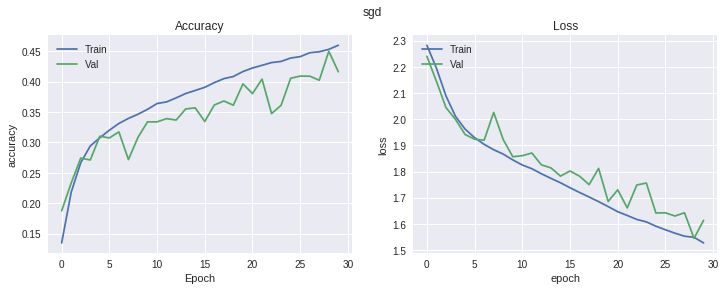

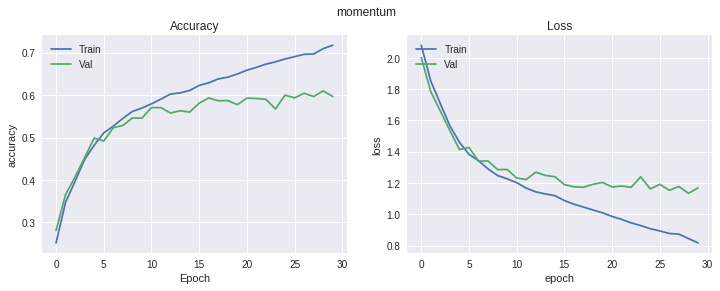

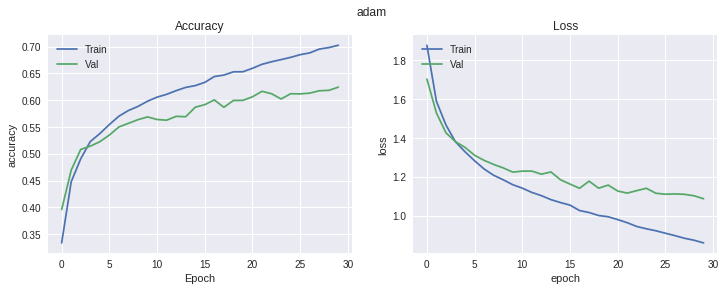

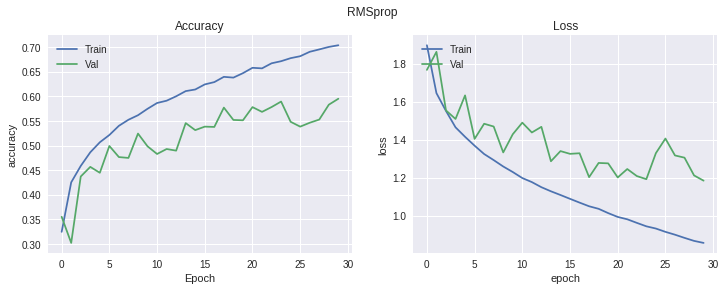

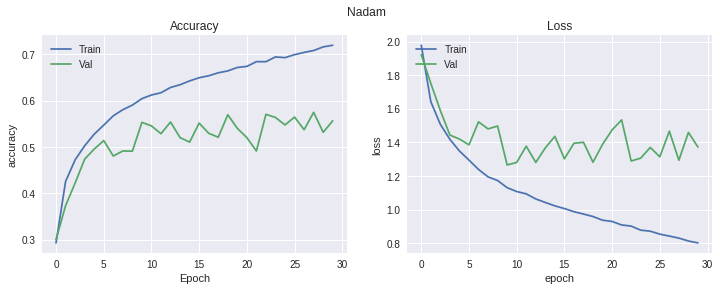

In [0]:
compare_optimization_methods('opt_methods')

По графикам видим, что используя sgd нейронка обучается в разы медленней, чем используя остальные методы.
Кажется, что самый хороший график получился при использовании adam. При использовании momentum график тоже неплохой и очень похож на график для adam. При использовании RMSprop и Nadam кривая обучения для валидационной выборки очень сильно прыгает, что не есть хорошо (в идеале хотим, чтобы график для валидации был похож на график для трейна, это бы означало, что мы постепенно идем к минимуму).

**Задание 1.4 (0.5 балла)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для сравнения будем проводить 4 эксперимента: <br>
1) Без BatchNormalization<br>
2) С BatchNormalization между сверткой и полносвязным слоем (оно же между свёрткой и активацией)<br>
3) С BatchNormalization между сверткой и первым полносвязным слоем (который на 100 нейронов) и между первым и вторым полносвязными слоями.<br>
4) С BatchNormalization между первым и вторым полносвязными слоями.<br>

В качестве метода оптимизации возьмем Adam так как он лучше всего себя показал в предыдущем пункте

In [0]:
def compare_batch_normalization(filename, optimizer, add_title='', verbose=0):
    histories = []
    titles = []
    
    # first model
    input_images = L.Input(shape=(32, 32, 3), name='images')
    cnn_layer = L.Conv2D(filters=10, kernel_size=(3, 3))(input_images)
    relu_layer = L.Activation('relu')(cnn_layer)
    pooling = L.MaxPool2D(pool_size=(2, 2))(relu_layer)
    flattened_vector = L.Flatten()(pooling)
    dense_layer = L.Dense(512, activation='relu')(flattened_vector)
    output = L.Dense(10, activation='softmax')(dense_layer)

    model = Model(inputs=[input_images], outputs=[output])
    if optimizer == 'momentum':
        optimizer = optimizers.SGD(momentum=0.9)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    histories.append(get_learning_curve(model, filename + '/first', verbose=verbose))
    titles.append(add_title + ' Without BatchNormalization')
    
    
    #second model
    input_images = L.Input(shape=(32, 32, 3), name='images')
    cnn_layer = L.Conv2D(filters=10, kernel_size=(3, 3))(input_images)
    norm_layer = L.BatchNormalization()(cnn_layer)
    relu_layer = L.Activation('relu')(norm_layer)
    pooling = L.MaxPool2D(pool_size=(2, 2))(relu_layer)
    flattened_vector = L.Flatten()(pooling)
    dense_layer = L.Dense(512, activation='relu')(flattened_vector)
    output = L.Dense(10, activation='softmax')(dense_layer)

    model = Model(inputs=[input_images], outputs=[output])
    if optimizer == 'momentum':
        optimizer = optimizers.SGD(momentum=0.9)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    histories.append(get_learning_curve(model, filename + '/second', verbose=verbose))
    titles.append(add_title + ' With BatchNormalization between CNN and Dense')

    
    #third model
    input_images = L.Input(shape=(32, 32, 3), name='images')
    cnn_layer = L.Conv2D(filters=10, kernel_size=(3, 3))(input_images)
    norm_layer = L.BatchNormalization()(cnn_layer)
    relu_layer = L.Activation('relu')(norm_layer)
    pooling = L.MaxPool2D(pool_size=(2, 2))(relu_layer)
    flattened_vector = L.Flatten()(pooling)
    dense_layer = L.Dense(512, activation='relu')(flattened_vector)
    norm_layer = L.BatchNormalization()(dense_layer)
    output = L.Dense(10, activation='softmax')(norm_layer)

    model = Model(inputs=[input_images], outputs=[output])
    if optimizer == 'momentum':
        optimizer = optimizers.SGD(momentum=0.9)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    histories.append(get_learning_curve(model, filename + '/third', verbose=verbose))
    titles.append(add_title + ' With BatchNormalization between CNN and Dense and between first and second Dense')
    
    # forth model
    input_images = L.Input(shape=(32, 32, 3), name='images')
    cnn_layer = L.Conv2D(filters=10, kernel_size=(3, 3))(input_images)
    relu_layer = L.Activation('relu')(cnn_layer)
    pooling = L.MaxPool2D(pool_size=(2, 2))(relu_layer)
    flattened_vector = L.Flatten()(pooling)
    dense_layer = L.Dense(512, activation='relu')(flattened_vector)
    norm_layer = L.BatchNormalization()(dense_layer)
    output = L.Dense(10, activation='softmax')(norm_layer)

    model = Model(inputs=[input_images], outputs=[output])
    if optimizer == 'momentum':
        optimizer = optimizers.SGD(momentum=0.9)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    histories.append(get_learning_curve(model, filename + '/forth', verbose=verbose))
    titles.append(add_title + ' With BatchNormalization between first and second Dense')
    
    show_learning_curve(histories, titles)

Для просмотра графиков нужно пролистать вниз, они будут после вывода (извиняюсь)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 3s 75us/step - loss: 1.8450 - acc: 0.3402 - val_loss: 1.6059 - val_acc: 0.4377
Epoch 2/30
40000/40000 [==============================] - 3s 68us/step - loss: 1.5092 - acc: 0.4714 - val_loss: 1.4882 - val_acc: 0.4750
Epoch 3/30
40000/40000 [==============================] - 3s 68us/step - loss: 1.3925 - acc: 0.5115 - val_loss: 1.3757 - val_acc: 0.5142
Epoch 4/30
40000/40000 [==============================] - 3s 69us/step - loss: 1.3101 - acc: 0.5435 - val_loss: 1.3340 - val_acc: 0.5251
Epoch 5/30
40000/40000 [==============================] - 3s 68us/step - loss: 1.2409 - acc: 0.5671 - val_loss: 1.2691 - val_acc: 0.5522
Epoch 6/30
40000/40000 [==============================] - 3s 69us/step - loss: 1.1801 - acc: 0.5882 - val_loss: 1.2487 - val_acc: 0.5579
Epoch 7/30
40000/40000 [==============================] - 3s 68us/step - loss: 1.1297 - acc: 0.6058 - val_loss: 1.2394 - val_acc

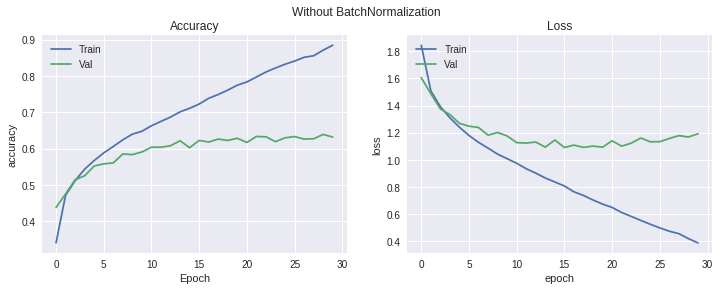

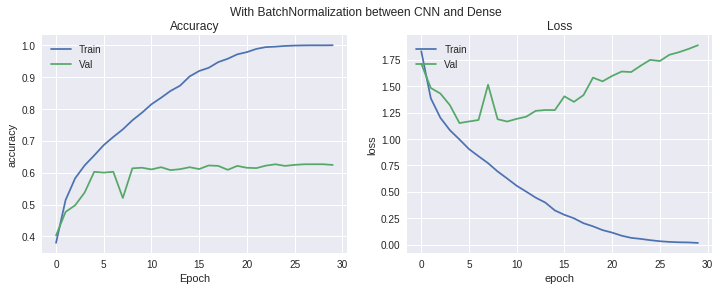

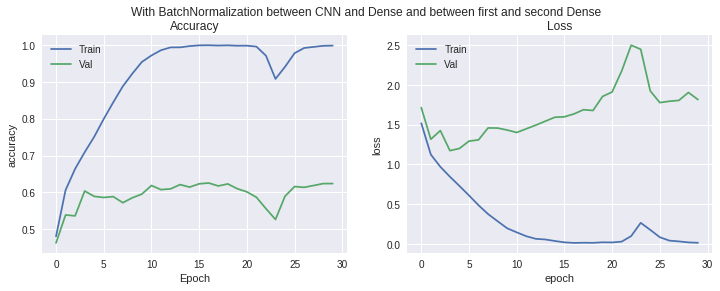

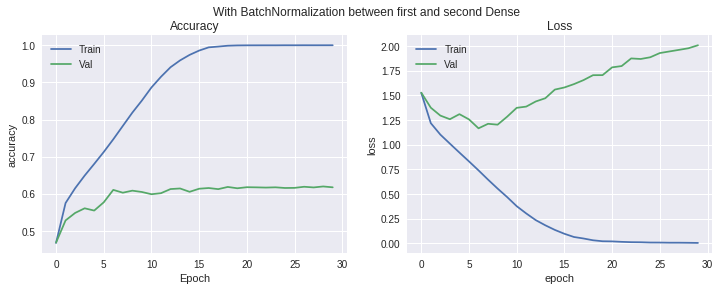

In [0]:
compare_batch_normalization('batch_norm', 'adam')

Как ни странно видим, что лучше всего в данном случае без BatchNormalization. В случаях, когда у нас есть BatchNormalization, модель, кажется, начинает переобучаться. Но можно заметить, что с BatchNormalization модель быстрей достигает метки 60% accuracy. Однако, если посмотреть на график для loss-а можно заметить, что без batch нормализации мы достигаем меньшего лосса, чем в остальных случаях.


**Задание 1.5 (0.5 балла)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%.

Будем рассматривать размеры батча равными 64, 128, ..., 4096.

In [0]:
def compare_batch_size(filename, optimizer):
    batch_sizes = 2 ** np.arange(6, 13)
    histories = []
    titles = []
    
    for size in batch_sizes:
        input_images = L.Input(shape=(32, 32, 3), name='images')
        cnn_layer = L.Conv2D(filters=10, kernel_size=(3, 3))(input_images)
        relu_layer = L.Activation('relu')(cnn_layer)
        pooling = L.MaxPool2D(pool_size=(2, 2))(relu_layer)
        flattened_vector = L.Flatten()(pooling)
        dense_layer = L.Dense(512, activation='relu')(flattened_vector)
        output = L.Dense(10, activation='softmax')(dense_layer)
        model = Model(inputs=[input_images], outputs=[output])
        if optimizer == 'momentum':
            optimizer = optimizers.SGD(momentum=0.9)
            model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        else:
            model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        titles.append('Batch size of {}'.format(size))
        histories.append(get_learning_curve(model, filename + '/{}'.format(size), batch_size=size, verbose=0))
        
    show_learning_curve(histories, titles)

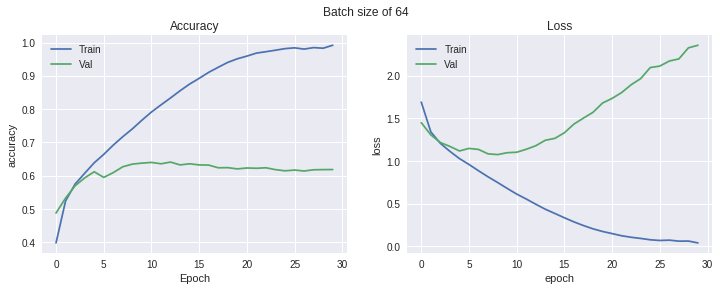

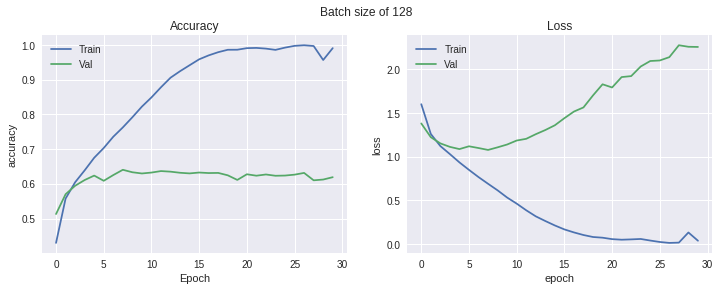

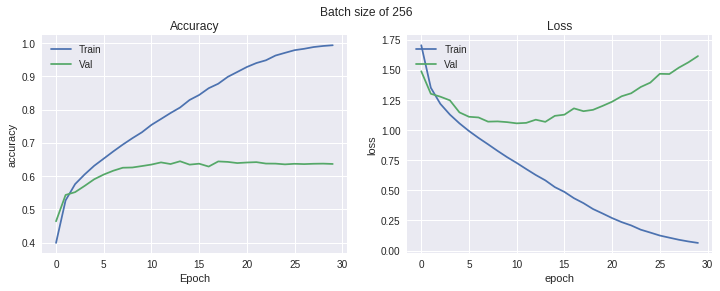

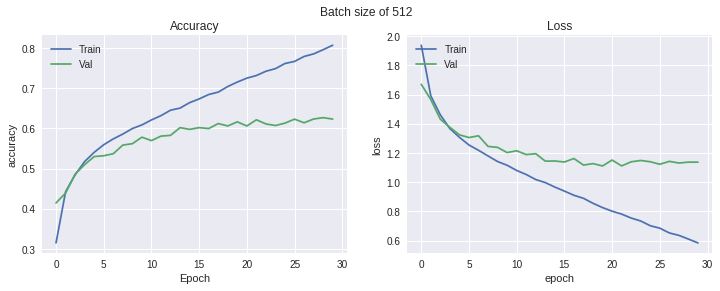

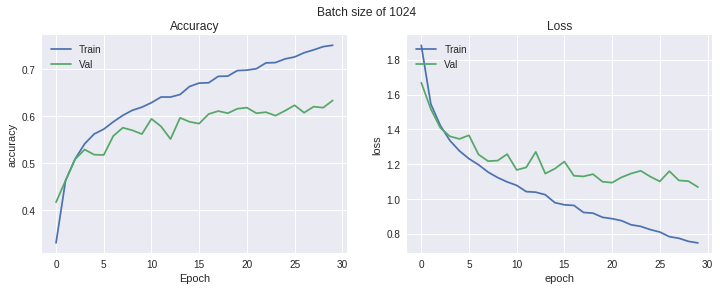

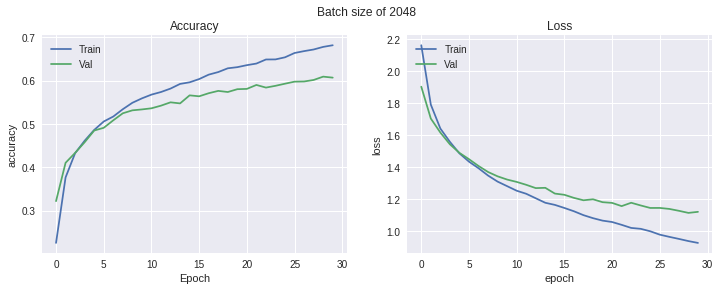

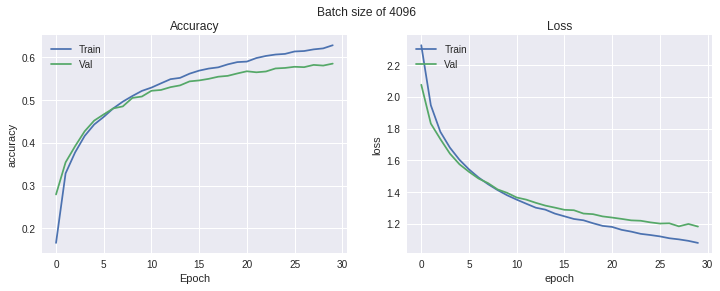

In [0]:
compare_batch_size('batch_size', 'adam')

При небольших размерах batch size (<=256) мы начинаем переобучаться, хоть и чуть быстрее достигаем метки 55%. Из оставшихся размеров батча быстрей всего достигаем метки 55% с batch size = 512.

**Задание 1.6 (0.5 балла)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [0]:
def compare_optimization_and_normalization(filename, verbose=0):
    opt_methods = ['sgd', 'momentum', 'adam', 'RMSprop', 'Nadam']
    histories = []
    titles = []
    for method in opt_methods:
        compare_batch_normalization(filename, method, add_title=method + '+', verbose=verbose)
      

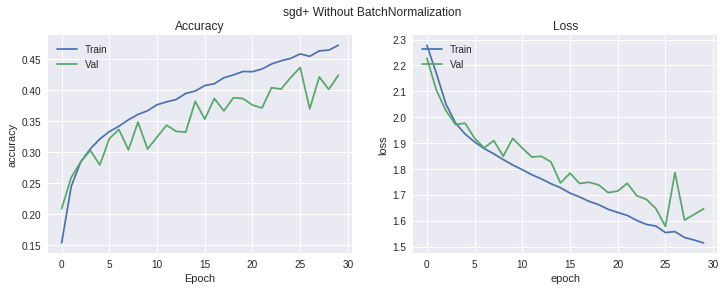

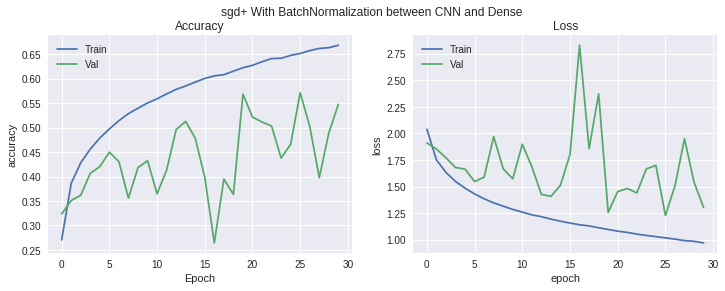

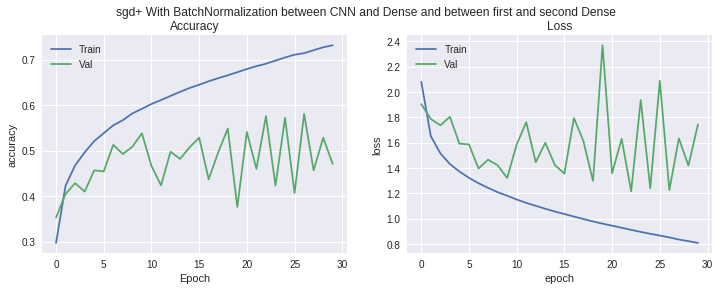

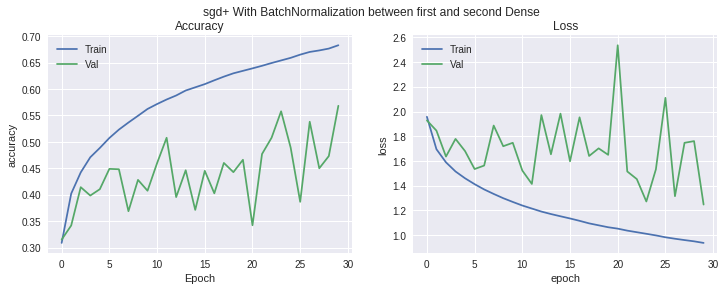

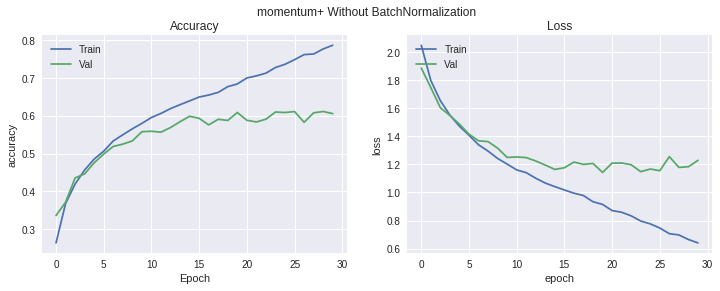

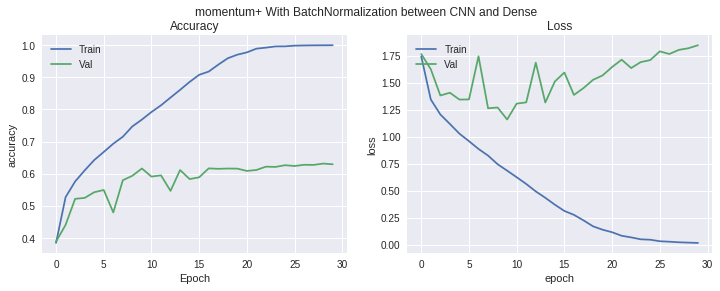

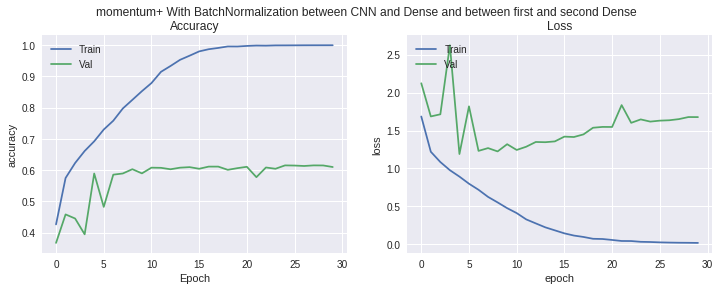

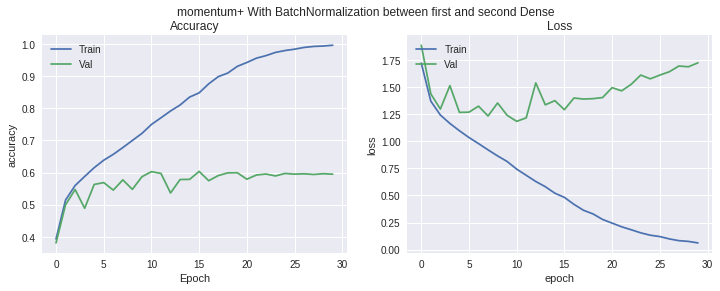

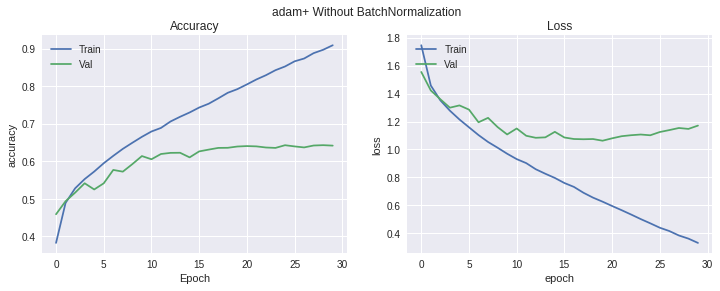

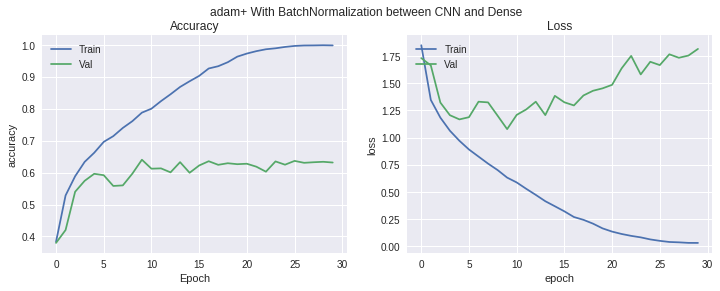

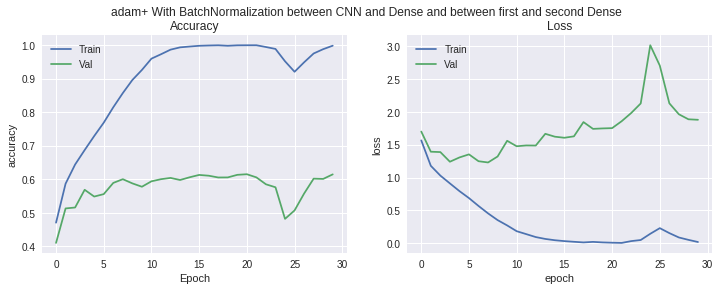

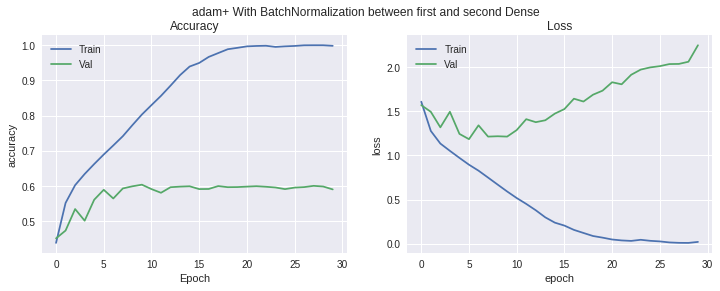

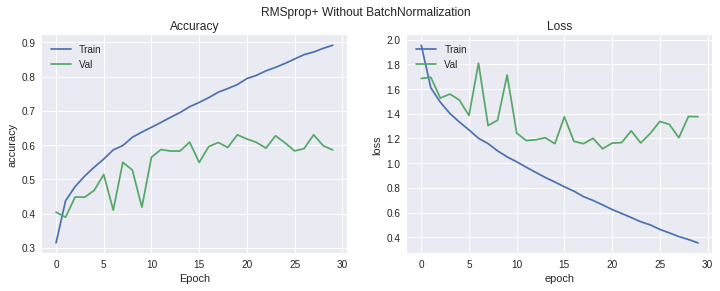

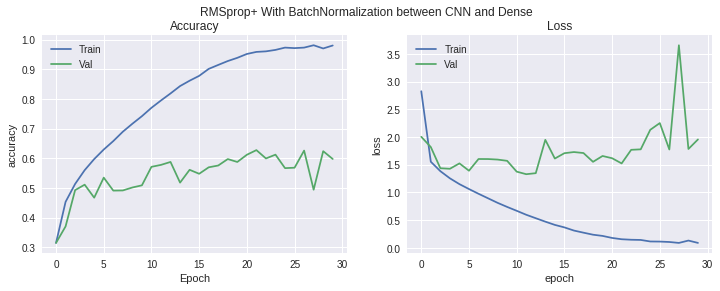

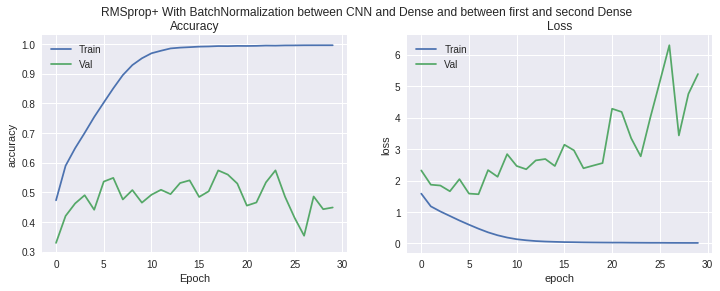

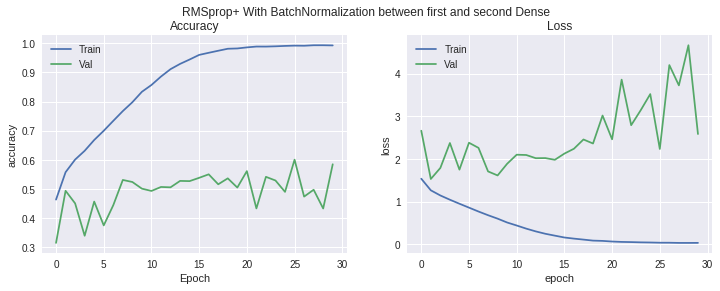

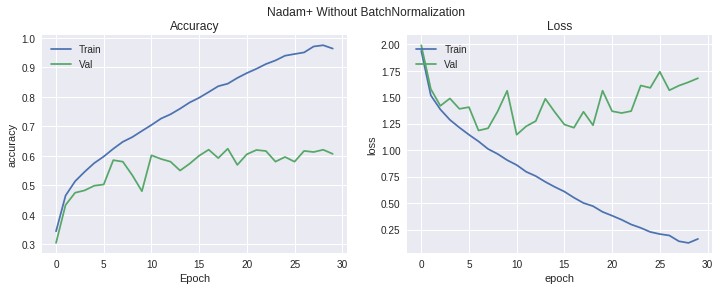

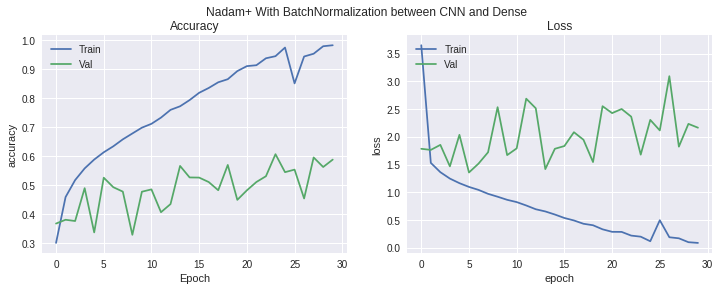

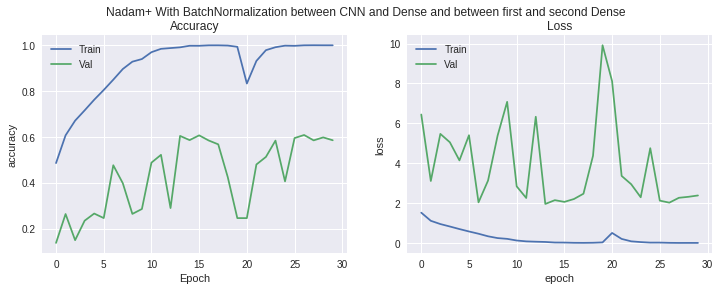

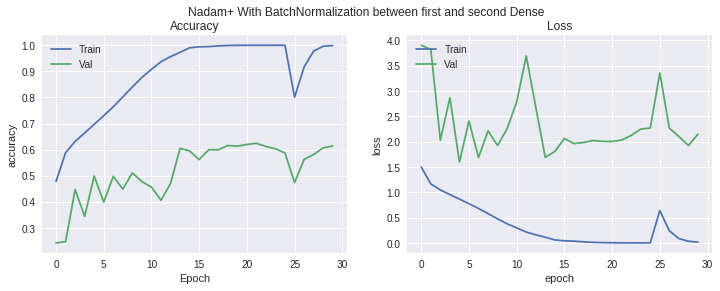

In [24]:
compare_optimization_and_normalization('optimizer_and_batch')

Из полученных графиков самым хорошим выглядит график обучения с adam-ом и без batch normalization. На нем мы не видим переобучения и он не сильно прыгает. Кроме того, именно в этом случае кажется, что средний acuuracy для валидации получился самым большим и, возможно, мог бы повыситься в течениии нескольких следующих эпох.

Напишите ваши выводы по проделанным экспериментам: что заработало, что — не очень. Постройте график кривых обучения (здесь или выше) с кривыми обучения разных архитектур.

Среди методов оптимизации можно выделить adam, который хорошо себя показал во всех экспериментах. Кривая обучения для валидации при использовании adam выглядит достаточно гладко, accuracy увеличивается, loss уменьшается. Все таки не зря он такой популярный.

Также неплохие графики обучения получились при использовании momentum, но, кажется, что adam все-таки лучше.

Странно, что с batch normalization получилось чуть хуже : accuracy получился примерно такой же, что и в архитектурах с batch нормализацией, но loss гораздо хуже. Кроме того, на графиках лосса для архитектур с batch нормализацией уже после 10-ой эпохи можно заметить переобучение. 

Также мы нашли более-менее оптимальный размер батча, 512.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (5 баллов)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

Почитав статью про VGG, я немного вдохновилась его блочной структурой, состоящей из сверток разного типа, и решила сделать что-то похожее. Также, как советовали в статье, я решила добавить l2 регуляризацию на веса, отвечающие за свертки. 

In [0]:
input_images = L.Input(shape=(32, 32, 3), name='images')

#first block
conv1 = L.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(0.001))(input_images)
norm1 = L.BatchNormalization()(conv1)
conv2 = L.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(0.001))(norm1)
norm2 = L.BatchNormalization()(conv2)
pool1 = L.MaxPool2D(pool_size=(2, 2), strides=2)(norm2)

#second block
conv3 = L.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', 
             kernel_regularizer=keras.regularizers.l2(0.001))(pool1)
norm3 = L.BatchNormalization()(conv3)

net = L.MaxPool2D(pool_size=(2, 2), strides=2)(norm3)

#third block
for i in range(2):
    conv = L.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(0.001))(net)
    net = L.BatchNormalization()(conv)
    
pool3 = L.MaxPool2D(pool_size=(2, 2), strides=2)(net)

#forth block
conv6 = L.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
             kernel_regularizer=keras.regularizers.l2(0.001))(pool3)
norm6 = L.BatchNormalization()(conv6)
    
pool4 = L.MaxPool2D(pool_size=(2, 2), strides=2)(norm6)

# dense block
flatten =  L.Flatten()(pool4)
dense1 = L.Dense(1024, activation='elu')(flatten)
dropout1 = L.Dropout(0.5)(dense1)
dense2 = L.Dense(512, activation='relu')(dropout1)
dropout2 = L.Dropout(0.75)(dense2)
dense3 = L.Dense(len(class_names), activation='softmax')(dropout2)

model = Model(inputs=[input_images], outputs=[dense3])
optimizer = optimizers.SGD(lr=0.005, momentum=0.9, nesterov=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [0]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(12))
callbacks_list = [tensorboard]
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 24s 592us/step - loss: 3.1407 - acc: 0.2792 - val_loss: 2.5479 - val_acc: 0.4060
Epoch 2/100
40000/40000 [==============================] - 22s 560us/step - loss: 2.4297 - acc: 0.4397 - val_loss: 2.3380 - val_acc: 0.4657
Epoch 3/100
40000/40000 [==============================] - 22s 560us/step - loss: 2.1035 - acc: 0.5358 - val_loss: 2.5028 - val_acc: 0.4607
Epoch 4/100
40000/40000 [==============================] - 22s 560us/step - loss: 1.8166 - acc: 0.6205 - val_loss: 1.8784 - val_acc: 0.6005
Epoch 5/100
40000/40000 [==============================] - 22s 559us/step - loss: 1.5710 - acc: 0.6896 - val_loss: 1.5422 - val_acc: 0.6957
Epoch 6/100
40000/40000 [==============================] - 22s 559us/step - loss: 1.4207 - acc: 0.7280 - val_loss: 1.4714 - val_acc: 0.6885
Epoch 7/100
40000/40000 [==============================] - 22s 559us/step - loss: 1.2836 - acc: 0.7648 - val_l

Момент истины: проверьте, какого качества достигла ваша сеть.

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.8019
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

Про аугументацию я вспомнила только в конце, после того, как уже достигла 80 %, а сейчас уже как-то не хочется обучаться еще раз, поэтому не сегодня.

Изначально сеть состояла из большего кол-ва сверток, но слишком долго обучалась и начинала быстро переобучаться. Я решила уменьшить кол-во слоев, стало получше, но переобучение все еще осталось. Как советовали в статье про VGG, я решила использовать l2-регуляризацию в слоях со свертками. После я решила поэксперементировать с разными размерами Dense-а и с различными активациями. В итоге получилось достичь 80%, хотя переобучение, как можно заметить, осталось.

Кажется, что можно было бы добавить побольше Dropout-ов, может это помогло бы от переобучения. 

Короче, странно, я не поняла почему такое сильное переобучение и что с этим еще можно сделать:(